In [1]:
import logging
import sys
import torch

sys.path.append("../lib")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

device = torch.device("cuda")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

### Step 1: Loading the model

We prepared our custom Steam dataset with over 80,000 games and corresponding images for each of them. We can read this dataset from the `data` directory.

In [2]:
import msgspec
from steam_model import SteamGame
from pathlib import Path

data_root = Path("./data/steam")
steam_games = data_root / "games.json"

games = msgspec.json.decode(steam_games.read_text(), type=list[SteamGame])
msgspec.to_builtins(games[0])

{'id': '553850',
 'url': 'https://store.steampowered.com/app/553850/HELLDIVERS_2/',
 'raw_name': 'HELLDIVERS_2',
 'url_type': 'app',
 'popularity_rank': 1,
 'page_information': {'type': 'game',
  'title': 'HELLDIVERS™ 2',
  'description': 'Digital Deluxe Edition Edition includes:‘DP-53\u202fSavior of the Free’ Armor Set.‘Will of the People’ Cape.‘MP-98 Knight’ Weapon.Super Citizen Status.Stratagem Hero Ship Game.‘Steeled Veterans’ Premium Warbond.',
  'price': 3999,
  'images': ['images/553850/ss_0c79f56fc7be1bd0102f2ca1c92c8f0900daf4fb.600x338.jpg',
   'images/553850/ss_33e684e9cb2517af1599f0ca2b57d65ee82c2e51.600x338.jpg',
   'images/553850/ss_8949ed7dd24a02d5ea13b08fc5c04fab400dc4bd.600x338.jpg',
   'images/553850/ss_50afbbc4d811c38fe9f64c1fc8d7eb9d9da6d24c.600x338.jpg',
   'images/553850/ss_cb276fe9f0b09683bdbc496f82b405dbe0ffa1f1.600x338.jpg',
   'images/553850/ss_d0ac3830833a68d19d4a97c70aef0fba20bf0761.600x338.jpg',
   'images/553850/ss_3b08a991443164a65f84f1bd9f1363e6c2ec4581.6

Let's define a few convenience functions to easily get an image for a given game:

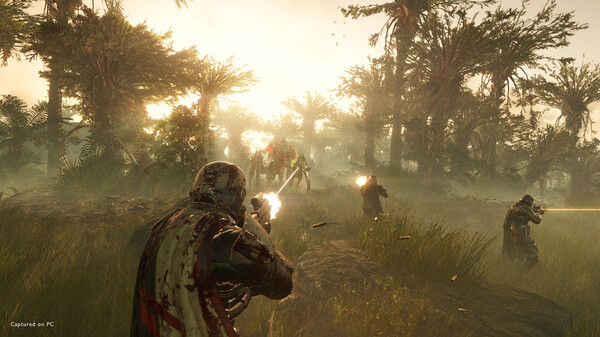

In [3]:
import PIL.Image
from PIL.Image import Image

def read_game_image(game: SteamGame, index: int) -> Image:
    return PIL.Image.open(data_root / game.page_information.images[index])

read_game_image(games[0], 0)

In [4]:
import pandas as pd

dataset = [
    { "id": game.id, "title": game.page_information.title, "image": game.page_information.images[-1], "genres": game.page_information.genres }
    for game
    in games[:1000]
]
base_df = pd.DataFrame.from_records(dataset)
one_hot_genres = base_df["genres"].str.join("|").str.get_dummies()

df = pd.concat([base_df, one_hot_genres], axis=1)
df.head()

,id,title,image,genres,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,...,Indie,Massively Multiplayer,Photo Editing,RPG,Racing,Simulation,Sports,Strategy,Utilities,Web Publishing
0,553850,HELLDIVERS™ 2,images/553850/ss_5dde7ea6922800dfece2a3a319cb6...,[Action],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1086940,Baldur's Gate 3,images/1086940/ss_3cc4e8cfcfb8a91d19d96f631f07...,"[Adventure, RPG, Strategy]",0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1172470,Apex Legends™,images/1172470/ss_6812fedeafc652ff34b20e0f07eb...,"[Action, Adventure, Free to Play]",1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1158310,Crusader Kings III,images/1158310/ss_ac0ea36ae1b379806728f0ec9220...,"[RPG, Simulation, Strategy]",0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
4,899770,Last Epoch,images/899770/ss_8c8166cac21b3b2b6a46e9a801133...,"[Action, Adventure, Indie, RPG]",1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [5]:
import torch

labels = df.columns[4:]
id2label = { id: label for id, label in enumerate(labels) }
label2id = { label: id for id, label in enumerate(labels) }

def get_labels_from_one_hot(one_hot: torch.Tensor) -> list[str]:
    return [id2label[id] for id in torch.nonzero(one_hot).squeeze().tolist()]

id2label

{0: 'Action',
 1: 'Adventure',
 2: 'Animation & Modeling',
 3: 'Audio Production',
 4: 'Casual',
 5: 'Design & Illustration',
 6: 'Early Access',
 7: 'Education',
 8: 'Free to Play',
 9: 'Game Development',
 10: 'Indie',
 11: 'Massively Multiplayer',
 12: 'Photo Editing',
 13: 'RPG',
 14: 'Racing',
 15: 'Simulation',
 16: 'Sports',
 17: 'Strategy',
 18: 'Utilities',
 19: 'Web Publishing'}

In [6]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_id = "facebook/dinov2-large"
processor_model_id = model_id

image_processor = AutoImageProcessor.from_pretrained(processor_model_id)
model = AutoModelForImageClassification.from_pretrained(
    model_id,
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)
model.to(device)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-23): 24 x Dinov2Layer(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=Fals

In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

class MultiLabelDataset(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame, transform: Compose):
        self.root = root
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        item = self.df.iloc[idx]

        # First, get the image
        image_path = self.root / item["image"]
        image = PIL.Image.open(image_path).convert("RGB")

        # Then, prepare the image for the model
        pixel_values = self.transform(image)

        # Get the labels as a PyTorch tensor
        labels = item[4:].values.astype(np.float32)
        labels = torch.from_numpy(labels)

        return pixel_values, labels
    
    def get_raw_image(self, idx: int) -> Image:
        item = self.df.iloc[idx]
        image_path = self.root / item["image"]
        return PIL.Image.open(image_path).convert("RGB")

BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

torch.Size([3, 256, 256]) ['Indie', 'Strategy']


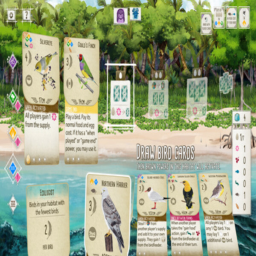

In [8]:
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

print(image_processor)
size = image_processor.size["shortest_edge"]
mean = image_processor.image_mean
std = image_processor.image_std

transform = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=mean, std=std),
])

# Split our data into training and validation sets
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

# Create and verify that the dataset works as we expect
train_dataset = MultiLabelDataset(root=data_root, df=train_df, transform=transform)
eval_dataset = MultiLabelDataset(root=data_root, df=eval_df, transform=transform)

pixel_values, labels = train_dataset[1]
print(pixel_values.shape, get_labels_from_one_hot(labels))

# Denormalize the pixel values to see that the image is also correctly loaded
unnormalized_image = (pixel_values.numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
PIL.Image.fromarray(unnormalized_image)

In [9]:
from transformers import TrainingArguments, Trainer, EvalPrediction
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

Batch = dict[str, torch.Tensor]

def data_collator(batch: list[tuple[torch.Tensor, torch.Tensor]]) -> Batch:
    pixel_values = torch.stack([item[0] for item in batch])
    labels = torch.stack([item[1] for item in batch])
    return { "pixel_values": pixel_values, "labels": labels }

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)

    return {'f1': f1_micro_average, 'roc_auc': roc_auc, 'accuracy': accuracy}

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result

training_args = TrainingArguments(
    output_dir="steam_genre_classifier",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=10,
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=100,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    tf32=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


In [10]:
trainer.train()

  0%|          | 0/5000 [00:00<?, ?it/s]

{'loss': 0.5135, 'grad_norm': 3.979240655899048, 'learning_rate': 1.8e-05, 'epoch': 0.2}
{'loss': 0.2878, 'grad_norm': 2.040982723236084, 'learning_rate': 3.6e-05, 'epoch': 0.4}
{'loss': 0.3548, 'grad_norm': 3.5033953189849854, 'learning_rate': 5.4e-05, 'epoch': 0.6}
{'loss': 0.3111, 'grad_norm': 8.295210838317871, 'learning_rate': 7.2e-05, 'epoch': 0.8}
{'loss': 0.3036, 'grad_norm': 2.2737016677856445, 'learning_rate': 9e-05, 'epoch': 1.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3206510543823242, 'eval_f1': 0.2749326145552561, 'eval_roc_auc': 0.5799259004735795, 'eval_accuracy': 0.08, 'eval_runtime': 2.8294, 'eval_samples_per_second': 70.686, 'eval_steps_per_second': 17.672, 'epoch': 1.0}
{'loss': 0.3181, 'grad_norm': 0.7070654034614563, 'learning_rate': 0.000108, 'epoch': 1.2}
{'loss': 0.3131, 'grad_norm': 0.9038407802581787, 'learning_rate': 0.000126, 'epoch': 1.4}
{'loss': 0.3038, 'grad_norm': 0.6334753036499023, 'learning_rate': 0.000144, 'epoch': 1.6}
{'loss': 0.2933, 'grad_norm': 0.9634850025177002, 'learning_rate': 0.00016199999999999998, 'epoch': 1.8}
{'loss': 0.3012, 'grad_norm': 0.6466357111930847, 'learning_rate': 0.00018, 'epoch': 2.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.30077099800109863, 'eval_f1': 0.2749326145552561, 'eval_roc_auc': 0.5799259004735795, 'eval_accuracy': 0.08, 'eval_runtime': 2.8144, 'eval_samples_per_second': 71.064, 'eval_steps_per_second': 17.766, 'epoch': 2.0}
{'loss': 0.2937, 'grad_norm': 0.5523239970207214, 'learning_rate': 0.000198, 'epoch': 2.2}
{'loss': 0.3089, 'grad_norm': 0.5375090837478638, 'learning_rate': 0.000216, 'epoch': 2.4}
{'loss': 0.2894, 'grad_norm': 0.8584454655647278, 'learning_rate': 0.000234, 'epoch': 2.6}
{'loss': 0.2791, 'grad_norm': 0.374749094247818, 'learning_rate': 0.000252, 'epoch': 2.8}
{'loss': 0.3056, 'grad_norm': 0.5577336549758911, 'learning_rate': 0.00027, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.29679611325263977, 'eval_f1': 0.2749326145552561, 'eval_roc_auc': 0.5799259004735795, 'eval_accuracy': 0.08, 'eval_runtime': 2.8157, 'eval_samples_per_second': 71.031, 'eval_steps_per_second': 17.758, 'epoch': 3.0}
{'loss': 0.282, 'grad_norm': 0.453183114528656, 'learning_rate': 0.000288, 'epoch': 3.2}
{'loss': 0.304, 'grad_norm': 0.40574532747268677, 'learning_rate': 0.000306, 'epoch': 3.4}
{'loss': 0.295, 'grad_norm': 0.43768084049224854, 'learning_rate': 0.00032399999999999996, 'epoch': 3.6}
{'loss': 0.2911, 'grad_norm': 0.568000853061676, 'learning_rate': 0.000342, 'epoch': 3.8}
{'loss': 0.3027, 'grad_norm': 0.640836775302887, 'learning_rate': 0.00036, 'epoch': 4.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.2966008484363556, 'eval_f1': 0.27586206896551724, 'eval_roc_auc': 0.5803249964252101, 'eval_accuracy': 0.05, 'eval_runtime': 2.8311, 'eval_samples_per_second': 70.643, 'eval_steps_per_second': 17.661, 'epoch': 4.0}
{'loss': 0.268, 'grad_norm': 0.41919592022895813, 'learning_rate': 0.00037799999999999997, 'epoch': 4.2}
{'loss': 0.3024, 'grad_norm': 0.47239407896995544, 'learning_rate': 0.000396, 'epoch': 4.4}
{'loss': 0.2976, 'grad_norm': 0.6679076552391052, 'learning_rate': 0.000414, 'epoch': 4.6}
{'loss': 0.3173, 'grad_norm': 0.5363107323646545, 'learning_rate': 0.000432, 'epoch': 4.8}
{'loss': 0.2818, 'grad_norm': 0.269962340593338, 'learning_rate': 0.00045, 'epoch': 5.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.2908240258693695, 'eval_f1': 0.3353437876960193, 'eval_roc_auc': 0.6068291293092225, 'eval_accuracy': 0.06, 'eval_runtime': 2.8406, 'eval_samples_per_second': 70.408, 'eval_steps_per_second': 17.602, 'epoch': 5.0}
{'loss': 0.2902, 'grad_norm': 0.3325481414794922, 'learning_rate': 0.000468, 'epoch': 5.2}
{'loss': 0.282, 'grad_norm': 0.40258607268333435, 'learning_rate': 0.000486, 'epoch': 5.4}
{'loss': 0.2933, 'grad_norm': 0.5415107011795044, 'learning_rate': 0.000504, 'epoch': 5.6}
{'loss': 0.3072, 'grad_norm': 0.445075124502182, 'learning_rate': 0.000522, 'epoch': 5.8}
{'loss': 0.2913, 'grad_norm': 0.35432177782058716, 'learning_rate': 0.00054, 'epoch': 6.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3077998459339142, 'eval_f1': 0.280794701986755, 'eval_roc_auc': 0.58231460712525, 'eval_accuracy': 0.06, 'eval_runtime': 2.8369, 'eval_samples_per_second': 70.5, 'eval_steps_per_second': 17.625, 'epoch': 6.0}
{'loss': 0.2977, 'grad_norm': 0.44612419605255127, 'learning_rate': 0.000558, 'epoch': 6.2}
{'loss': 0.287, 'grad_norm': 0.43847325444221497, 'learning_rate': 0.000576, 'epoch': 6.4}
{'loss': 0.2843, 'grad_norm': 0.42567548155784607, 'learning_rate': 0.000594, 'epoch': 6.6}
{'loss': 0.3085, 'grad_norm': 0.47209370136260986, 'learning_rate': 0.000612, 'epoch': 6.8}
{'loss': 0.2971, 'grad_norm': 0.33585676550865173, 'learning_rate': 0.0006299999999999999, 'epoch': 7.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.2953358590602875, 'eval_f1': 0.27530364372469635, 'eval_roc_auc': 0.5800704927234349, 'eval_accuracy': 0.08, 'eval_runtime': 2.8275, 'eval_samples_per_second': 70.733, 'eval_steps_per_second': 17.683, 'epoch': 7.0}
{'loss': 0.2919, 'grad_norm': 0.31461992859840393, 'learning_rate': 0.0006479999999999999, 'epoch': 7.2}
{'loss': 0.2973, 'grad_norm': 0.6021695137023926, 'learning_rate': 0.0006659999999999999, 'epoch': 7.4}
{'loss': 0.299, 'grad_norm': 0.3903978765010834, 'learning_rate': 0.000684, 'epoch': 7.6}
{'loss': 0.2841, 'grad_norm': 0.3017593026161194, 'learning_rate': 0.000702, 'epoch': 7.8}
{'loss': 0.2931, 'grad_norm': 0.44482317566871643, 'learning_rate': 0.00072, 'epoch': 8.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.30394160747528076, 'eval_f1': 0.2564102564102564, 'eval_roc_auc': 0.572904372768424, 'eval_accuracy': 0.07, 'eval_runtime': 2.5572, 'eval_samples_per_second': 78.211, 'eval_steps_per_second': 19.553, 'epoch': 8.0}
{'loss': 0.2947, 'grad_norm': 0.5613442659378052, 'learning_rate': 0.0007379999999999999, 'epoch': 8.2}
{'loss': 0.3068, 'grad_norm': 0.5729749798774719, 'learning_rate': 0.0007559999999999999, 'epoch': 8.4}
{'loss': 0.2778, 'grad_norm': 0.2774753272533417, 'learning_rate': 0.000774, 'epoch': 8.6}
{'loss': 0.2853, 'grad_norm': 0.5199339985847473, 'learning_rate': 0.000792, 'epoch': 8.8}
{'loss': 0.284, 'grad_norm': 0.22422881424427032, 'learning_rate': 0.00081, 'epoch': 9.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.28921520709991455, 'eval_f1': 0.2, 'eval_roc_auc': 0.5533668118636073, 'eval_accuracy': 0.065, 'eval_runtime': 2.5513, 'eval_samples_per_second': 78.392, 'eval_steps_per_second': 19.598, 'epoch': 9.0}
{'loss': 0.2857, 'grad_norm': 0.3425118625164032, 'learning_rate': 0.000828, 'epoch': 9.2}
{'loss': 0.2928, 'grad_norm': 0.37929049134254456, 'learning_rate': 0.000846, 'epoch': 9.4}
{'loss': 0.2885, 'grad_norm': 0.3592582643032074, 'learning_rate': 0.000864, 'epoch': 9.6}
{'loss': 0.2929, 'grad_norm': 0.2501191198825836, 'learning_rate': 0.000882, 'epoch': 9.8}
{'loss': 0.2873, 'grad_norm': 0.331413596868515, 'learning_rate': 0.0009, 'epoch': 10.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.29524052143096924, 'eval_f1': 0.14442700156985872, 'eval_roc_auc': 0.5353504041113285, 'eval_accuracy': 0.04, 'eval_runtime': 2.5546, 'eval_samples_per_second': 78.289, 'eval_steps_per_second': 19.572, 'epoch': 10.0}
{'loss': 0.2873, 'grad_norm': 0.22923605144023895, 'learning_rate': 0.0008979999999999999, 'epoch': 10.2}
{'loss': 0.2839, 'grad_norm': 0.2534525692462921, 'learning_rate': 0.000896, 'epoch': 10.4}
{'loss': 0.2841, 'grad_norm': 0.3703628182411194, 'learning_rate': 0.0008939999999999999, 'epoch': 10.6}
{'loss': 0.289, 'grad_norm': 0.23477055132389069, 'learning_rate': 0.000892, 'epoch': 10.8}
{'loss': 0.2962, 'grad_norm': 0.2506985664367676, 'learning_rate': 0.0008900000000000001, 'epoch': 11.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.2887492775917053, 'eval_f1': 0.2601398601398601, 'eval_roc_auc': 0.5742259779451467, 'eval_accuracy': 0.08, 'eval_runtime': 2.5515, 'eval_samples_per_second': 78.384, 'eval_steps_per_second': 19.596, 'epoch': 11.0}
{'loss': 0.2811, 'grad_norm': 0.33463674783706665, 'learning_rate': 0.000888, 'epoch': 11.2}
{'loss': 0.2755, 'grad_norm': 0.29154473543167114, 'learning_rate': 0.000886, 'epoch': 11.4}
{'loss': 0.3049, 'grad_norm': 0.35525164008140564, 'learning_rate': 0.000884, 'epoch': 11.6}
{'loss': 0.2827, 'grad_norm': 0.21519190073013306, 'learning_rate': 0.000882, 'epoch': 11.8}
{'loss': 0.2885, 'grad_norm': 0.23825746774673462, 'learning_rate': 0.0008799999999999999, 'epoch': 12.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.2910606265068054, 'eval_f1': 0.01092896174863388, 'eval_roc_auc': 0.5021891586758551, 'eval_accuracy': 0.01, 'eval_runtime': 2.5486, 'eval_samples_per_second': 78.474, 'eval_steps_per_second': 19.619, 'epoch': 12.0}
{'loss': 0.2964, 'grad_norm': 0.18005801737308502, 'learning_rate': 0.000878, 'epoch': 12.2}
{'loss': 0.2738, 'grad_norm': 0.25341615080833435, 'learning_rate': 0.000876, 'epoch': 12.4}
{'loss': 0.2966, 'grad_norm': 0.28953325748443604, 'learning_rate': 0.000874, 'epoch': 12.6}
{'loss': 0.2726, 'grad_norm': 0.2633492052555084, 'learning_rate': 0.0008719999999999999, 'epoch': 12.8}
{'loss': 0.2876, 'grad_norm': 0.291061669588089, 'learning_rate': 0.00087, 'epoch': 13.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.29084154963493347, 'eval_f1': 0.27828348504551365, 'eval_roc_auc': 0.581357417102222, 'eval_accuracy': 0.045, 'eval_runtime': 2.5752, 'eval_samples_per_second': 77.665, 'eval_steps_per_second': 19.416, 'epoch': 13.0}
{'loss': 0.2772, 'grad_norm': 0.526461660861969, 'learning_rate': 0.000868, 'epoch': 13.2}
{'loss': 0.2853, 'grad_norm': 0.25653740763664246, 'learning_rate': 0.0008659999999999999, 'epoch': 13.4}
{'loss': 0.2811, 'grad_norm': 0.2582589387893677, 'learning_rate': 0.000864, 'epoch': 13.6}
{'loss': 0.2867, 'grad_norm': 0.3833664059638977, 'learning_rate': 0.0008619999999999999, 'epoch': 13.8}


KeyboardInterrupt: 

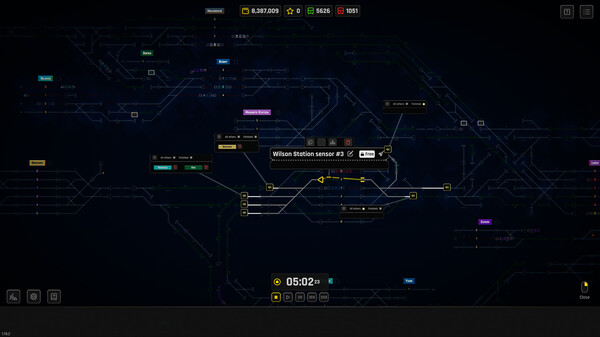

In [ ]:
# inferred_index = 50
# inferred_index = 80
# inferred_index = 140
# inferred_index = 150
inferred_index = 170

img = eval_dataset.get_raw_image(inferred_index)
img

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model="./steam_genre_classifier/with-tf32")
classifier(img)

[{'label': 'Indie', 'score': 0.993105947971344},
 {'label': 'Simulation', 'score': 0.9674526453018188},
 {'label': 'Strategy', 'score': 0.9491877555847168},
 {'label': 'Early Access', 'score': 0.20456399023532867},
 {'label': 'Action', 'score': 0.06617897003889084}]